<HDF5 file "results.h5" (mode r)>
regressor_loss_history_test
[]
regressor_loss_history_train
[ 12207.58769531   5131.58046875   5315.72675781   2716.03745117
   2608.83120117   1734.81870117   1220.66291504    469.29343872
    402.49089355    550.212146      422.91211548    386.17484741
    358.62362671    338.05480957    334.01380615    323.78831177
    315.5788208     310.68699951    305.02001343    294.37804565
    287.59406128    286.73306274    289.22014771    287.62533569
    292.76102905    271.77199707    273.26736755    264.88537292
    270.42930298    272.88299866    268.8245636     265.56099854
    267.69527283    261.85532532    264.98877563    251.7981842
    261.81442261    260.03314819    267.22441711    278.63798828
    279.16110229    275.50507202    276.84893799    275.54067383
    260.62937622    258.64499817    262.67400208    246.34358521
    267.21274414    272.6291626 ]
regressor_pred
[ 312.5758667   138.62826538  168.03553772 ...,  349.67105103   21.69195938
  

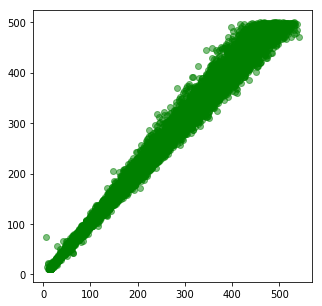

In [2]:
import numpy as np
import os
import sys
import re
import glob
import h5py
import numpy as np
from os.path import join
import matplotlib.pyplot as plt
import torch
import h5py as h5
import torch.utils.data as data
import setGPU

%matplotlib inline
if __package__ is None:
    sys.path.append(os.path.realpath("/nfshome/mliu/Triforce_CaloML/")) 
    # need this to load the model, has dependencies on module Regression
from Analysis import Default_Analyzer
import Loader.loader as loader
# check what is in the dataset
dataset_base = "/nfshome/mliu/Triforce_CaloML/Output/regression_fixedangle_gamma_epoch50_test_10k/"
el_path = os.path.join(dataset_base,'results.h5')
elf = h5py.File(el_path,'r')
print(elf)
for key in elf.keys():
    print(key)
    print(np.array(elf[key]))
plt.figure(figsize=(5,5))
plt.scatter(elf['regressor_pred'], elf['regressor_true'], color='g', alpha = 0.5)
plt.show()

In [2]:
#load the file and model. need generator for this???
trained_regressor = torch.load('../Output/regression_fixedangle_gamma_epoch50_test3/saved_regressor.pt')
OutPath="./"
basePath = "/data/shared/LCDLargeWindow/fixedangle/Pi0Escan/"
samplePath = [basePath + "Pi0Escan_1_1.h5"]
#, basePath + "GammaEscan/GammaEscan*.h5"]
classPdgID = [111]
#, 22] # absolute IDs corresponding to paths above
eventsPerFile = 10000
trainRatio = 0.5
batchSize = 100

####################################
# Load files and set up generators #
####################################

print('-------------------------------')
print('Loading Files')

nParticles = len(samplePath)
particleFiles = [[]] * nParticles
for i, particlePath in enumerate(samplePath):
    particleFiles[i] = glob.glob(particlePath)

filesPerParticle = len(particleFiles[0])
nTrain = int(filesPerParticle * trainRatio)
nTest = filesPerParticle - nTrain
trainFiles = []
testFiles = []
for i in range(filesPerParticle):
    newFiles = []
    for j in range(nParticles):
        newFiles.append(particleFiles[j][i])
    if i < nTrain:
        trainFiles.append(newFiles)
    else:
        testFiles.append(newFiles)
eventsPerFile *= nParticles

testSet = loader.HDF5Dataset(testFiles, eventsPerFile, classPdgID)
testLoader = data.DataLoader(dataset=testSet,batch_size=batchSize,num_workers=0)

-------------------------------
Loading Files


In [3]:
if not os.path.exists(OutPath): os.makedirs(OutPath)
out_file = h5.File(OutPath+"predictions11.h5")
analyzer = Default_Analyzer.Analyzer()
output = analyzer.analyze_net([None, trained_regressor, None], testLoader, out_file)

RuntimeError: cuda runtime error (2) : out of memory at /pytorch/torch/lib/THC/generic/THCStorage.cu:58

In [4]:
predictions = [ output[1][i][0].cpu().numpy() for i in range(len(output[1]))]
pred = np.concatenate(predictions).ravel()
truevalues = [ output[1][i][1].cpu().numpy() for i in range(len(output[1]))]
true = np.concatenate(truevalues).ravel()

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


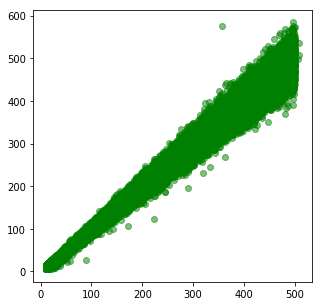

In [23]:
plt.figure(figsize=(5,5))
plt.scatter(true, pred, color='g', alpha = 0.5)
#plt.plot(true,(true-pred)/true)
print(type(true))
print(type(pred))

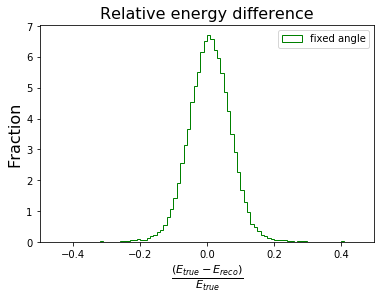

In [19]:
def RelDif(target,pred):
    difference = target-pred   
    # the histogram of the data  
    mean = np.mean(difference)
    std = np.std(difference)  # standard deviation    
    error=std/np.sqrt(len(target))
    return difference,mean,std,error
        
nbins = np.arange(-.5,.5,0.01)    
fixed_diff,fixed_mean,fixed_std,fixed_error = RelDif(true,pred)
#var_diff,var_mean,var_std,var_error = RelDif(true_var,el_var_ecale+el_var_hcale)

plt.hist(fixed_diff/true, nbins, normed=1, color='green', histtype='step',linestyle='solid',label="fixed angle")
#plt.hist(var_diff/true_var, nbins, normed=1, color='blue', histtype='step',linestyle='solid',label="variable angle")
plt.xlim(-.5,.5)
plt.xlabel('Relative difference between true and predicted energy (%)',size=16)
plt.xlabel(r'$\frac{(E_{true} - E_{reco})}{E_{true}}$',size=16)
plt.ylabel('Fraction',size=16)
plt.title("Relative energy difference",size=16)
plt.legend(loc='best')
plt.show()

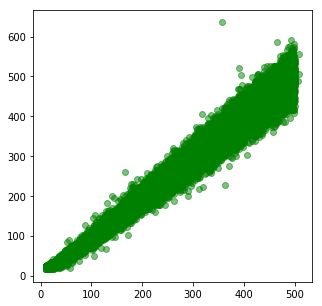

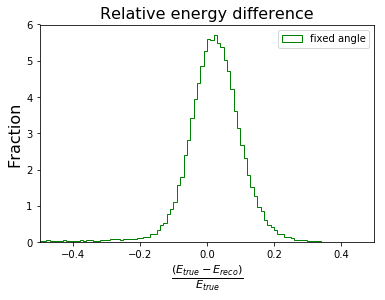

In [29]:
dataset_base = "/nfshome/mliu/Triforce_CaloML/Output/regression_fixedangle_gamma_epoch50_test0/"
el_path = os.path.join(dataset_base,'results.h5')
elf = h5py.File(el_path,'r')
plt.figure(figsize=(5,5))
plt.scatter(elf['regressor_true'], elf['regressor_pred'], color='g', alpha = 0.5)
plt.show()

def RelDif(target,pred):
    difference = target-pred   
    # the histogram of the data  
    mean = np.mean(difference)
    std = np.std(difference)  # standard deviation    
    error=std/np.sqrt(len(target))
    return difference,mean,std,error
true = np.array(elf['regressor_true'])
pred = np.array( elf['regressor_pred'])
nbins = np.arange(-.5,.5,0.01)    
fixed_diff,fixed_mean,fixed_std,fixed_error = RelDif(true,pred)
#var_diff,var_mean,var_std,var_error = RelDif(true_var,el_var_ecale+el_var_hcale)

plt.hist(fixed_diff/true, nbins, normed=1, color='green', histtype='step',linestyle='solid',label="fixed angle")
#plt.hist(var_diff/true_var, nbins, normed=1, color='blue', histtype='step',linestyle='solid',label="variable angle")
plt.xlim(-.5,.5)
plt.xlabel('Relative difference between true and predicted energy (%)',size=16)
plt.xlabel(r'$\frac{(E_{true} - E_{reco})}{E_{true}}$',size=16)
plt.ylabel('Fraction',size=16)
plt.title("Relative energy difference",size=16)
plt.legend(loc='best')
plt.show()